In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


In [2]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

1. 사진 준비

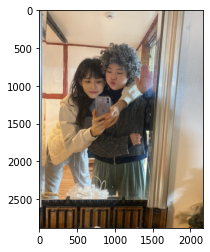

In [3]:
# img_path 경로에 있는 사진 파일 읽어오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/gh.png'  
img_orig = cv2.imread(img_path)

# 이미지 색상 채널을 BGR에서 RGB로 변경
# plt.imshow: 저장된 데이터를 이미지 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# plt.show(): 현재 열려있는 모든 figure를 표시 
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

2. 사람 분리하기 (segmentation)

In [4]:
# PixelLib을 통해 DeepLab 모델 다운받기

# 환경변수 HOME 값을 return & 저장할 경로 
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 저장할 파일명
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 후 model_file로 저장
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ffb00b7a9a0>)

In [5]:
# 다운로드한 모델을 이용해 사용할 segmentation model 생성

#PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model = semantic_segmentation() 
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file)

In [6]:
# segmentAsPascalvoc()함수를 호출하여 입력된 이미지를 분할
# output: BGR 순서로 채널 배치
# segvalues: class_ids, mask를 key값으로 갖는 딕셔너리

# 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path)
print(output.shape)

(2880, 2160, 3)


In [7]:
# 참고: http://host.robots.ox.ac.uk/pascal/VOC/

#pascalvoc 데이터의 라벨종류 --> background를 제외하면 20개 
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(class_id, LABEL_NAMES[class_id])
    # person 라벨을 가진 경우 ID 값에 class_id 저장
    if LABEL_NAMES[class_id] == 'person':
        ID = class_id

0 background
15 person
16 pottedplant


In [8]:
# 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[ID] # (pacalvoc에 LABEL_NAMES 15번째인 사람) 사람에 해당하는 값 출력

array([192, 128, 128])

In [9]:
# RGB 채널로된 colormap을 output에 맞는 BGR 채널로 변경
# (128,128,192) # 색상순서 변경 ()

# 사람에 해당하는 컬러맵 배열을 seg_color 변수에 저장
seg_color = colormap[ID].copy()
seg_color[2] = colormap[ID][0]
seg_color[0] = colormap[ID][2]
seg_color

array([128, 128, 192])

(2880, 2160)


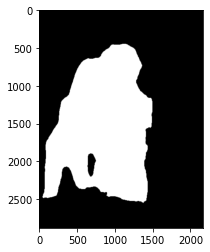

In [10]:
"""
    output 픽셀 별로 사람에 해당하는 값은 1, 아니면 0
    사람을 제외한 나머지는 gray(cmap으로 설정)로 출력
"""

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

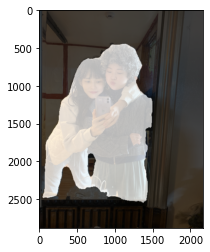

In [11]:
"""
    1, 0으로 구성된 seg_map을 가져와 흑백으로 구성된 color_mask를 생성한 뒤 
    img_show: 원본이미지를 할당
    이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
"""
# 
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 설정한 colormap색상으로 변경 
# 참고: https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html#ga9a805d8262bcbe273f16be9ea2055a65
# color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_PINK)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.3, color_mask, 0.7, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

3. 배경 흐리게 하기

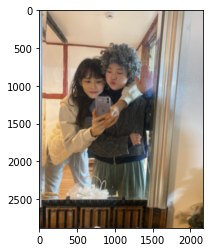

In [12]:
# (13,13)은 blurring kernel size로 커질수록 흐려짐
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

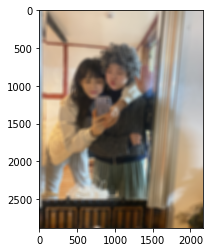

In [13]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

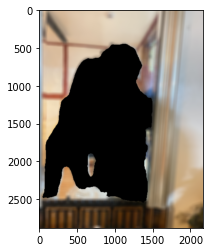

In [14]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

4. 흐린 배경과 원본 합성

#### (사진1) 내사진 셸로우 포커스 적용

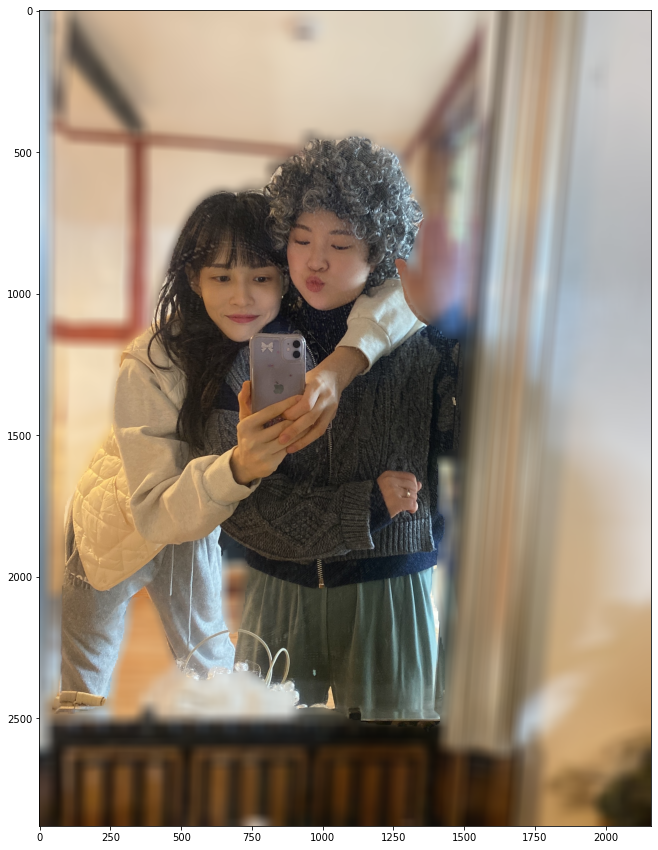

In [15]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.figure(figsize=(12,15))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 실습을 위한 코드 구성 및 결과

In [45]:

def read_file(file_path):
    # TODO: 함수 별 PEP8에 따른 설명 추가하기
    """
        img_path 경로에 있는 사진 파일을 읽어서 RGB 파일로 변환해서 돌려줌
        
        - INPUT
        file_path: 이미지 파일이 저장된 디렉토리
    """
    # HOME 환경변수 값을 가져와 file_path와 합친 뒤 img_path 변수 생성
    img_path = os.getenv('HOME')+file_path
    # img_path 경로에 있는 사진 파일 읽어오기
    
    return img_path, cv2.imread(img_path)

def change_color_channel(img_file, color_channel=cv2.COLOR_BGR2RGB):
    # TODO: 함수 별 PEP8에 따른 설명 추가하기
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
    return cv2.cvtColor(img_file, color_channel)
    
def show_img(img_file, figsize=(6,8), cmap='viridis'):
    # TODO: 함수 별 PEP8에 따른 설명 추가하기
    # plt.imshow: 저장된 데이터를 이미지 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
    # plt.show(): 현재 열려있는 모든 figure를 표시 
    plt.figure(figsize=figsize)
    plt.imshow(img_file, cmap=cmap)
    plt.show()


def seg_img(img_path, img_orig, label='person'):
    # TODO: 함수 별 PEP8에 따른 설명 추가하기
    # TODO: 내부 기능 별 함수 재구성
    """
        시간이 없어서 모듈화를 못하고
        실험을 빨리하기 위해서 필요한 코드만 넣어서 돌릴 수 있도록 묶어 놓음
        
        - INPUT
        img_path:
        img_orig:
        label: 찾으려는 대상이 사람이라면 person 개라면 dog
        
        - 최종 이미지만 return
    """
    # segmentAsPascalvoc()함수를 호출하여 입력된 이미지를 분할
    # output: BGR 순서로 채널 배치
    # segvalues: class_ids, mask를 key값으로 갖는 딕셔너리

    # 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
    segvalues, output = model.segmentAsPascalvoc(img_path)
    # print(output.shape)

    # 참고: http://host.robots.ox.ac.uk/pascal/VOC/
    #pascalvoc 데이터의 라벨종류 --> background를 제외하면 20개 
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]

    #segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
    for class_id in segvalues['class_ids']:
        print(class_id, LABEL_NAMES[class_id])
        # person 라벨을 가진 경우 ID 값에 class_id 저장
        if LABEL_NAMES[class_id] == label:
            ID = class_id

    # 사람에 해당하는 컬러맵 배열을 seg_color 변수에 저장
    seg_color = colormap[ID].copy()
    seg_color[2] = colormap[ID][0]
    seg_color[0] = colormap[ID][2] 


    """
        output 픽셀 별로 사람에 해당하는 값은 1, 아니면 0
        사람을 제외한 나머지는 gray(cmap으로 설정)로 출력
    """

    seg_map = np.all(output==seg_color, axis=-1) 


    """
        1, 0으로 구성된 seg_map을 가져와 흑백으로 구성된 color_mask를 생성한 뒤 
        img_show: 원본이미지를 할당
        이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
    """
    # 
    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # (13,13)은 blurring kernel size를 뜻합니다
    img_orig_blur = cv2.blur(img_orig, (50,50))


    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    # np.where(조건, 참일때, 거짓일때)
    # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
    # 아닌 영역은 블러된 이미지 값을 사용합니다.
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    return img_concat

### 흔들린 사진

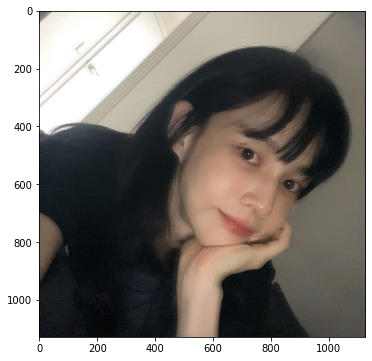

In [28]:
# 이미지 파일 경로 및 파일 가져오기
img_path, img_org = read_file(file_path='/aiffel/human_segmentation/images/shaking.png')
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
show_img(change_color_channel(img_org))

#### (사진2) 흔들린 사진 셸로우 포커스 적용

0 background
15 person


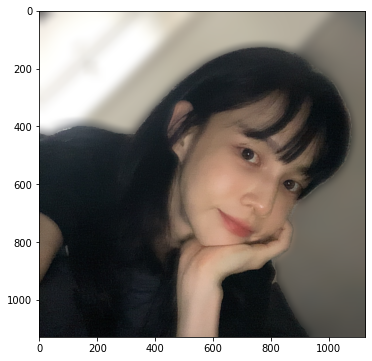

In [29]:
# 블러 처리 후 이미지 가져오기
img_res = seg_img(img_path, img_org)
show_img(change_color_channel(img_res))

- 흔들린 사진의 경우 얼굴의 경우 분리가 잘 된 것 같음
- 하지만 왼쪽 어깨 부분 머리카락은 배경 처리된 것으로 보임

### 어두운 사진

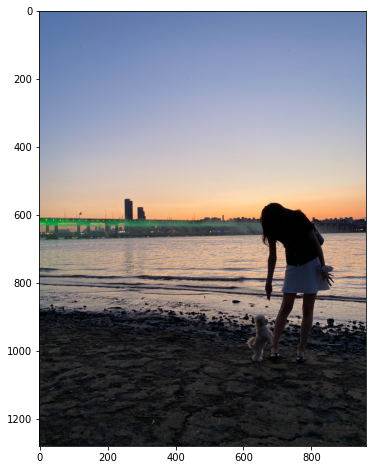

In [46]:
# 이미지 파일 경로 및 파일 가져오기
img_path, img_org = read_file(file_path='/aiffel/human_segmentation/images/dark.png')
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
show_img(change_color_channel(img_org))

#### (사진3) 어두운 사진 셸로우 포커스

0 background
12 dog
13 horse
15 person


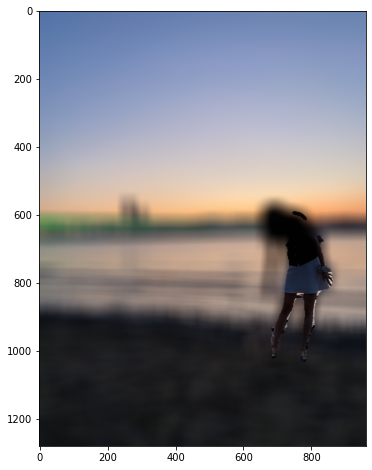

In [38]:
# 블러 처리 후 이미지 가져오기
img_res = seg_img(img_path, img_org)
show_img(change_color_channel(img_res))

- 몸은 있지만 얼굴는 사진이다보니 거의 대부분을 배경으로 인식한 듯함
- 재밌는 건 output의 라벨을 보면 horse라고 나와 있는데 아마 나를 말로 인식한 듯..?

0 background
12 dog
13 horse
15 person


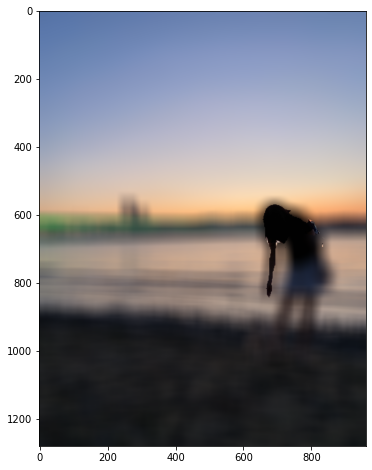

In [47]:
# 블러 처리 후 이미지 가져오기
img_res = seg_img(img_path, img_org, 'horse')
show_img(change_color_channel(img_res))

0 background
12 dog
13 horse
15 person


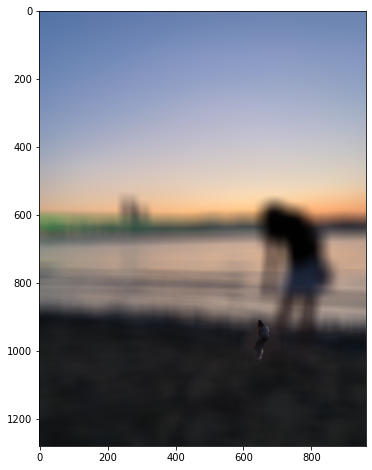

In [48]:
# 블러 처리 후 이미지 가져오기
img_res = seg_img(img_path, img_org, 'dog')
show_img(change_color_channel(img_res))

- 말과 강아지로 다시 해봐도 여전히 인식은 안됨

### 강아지 사진

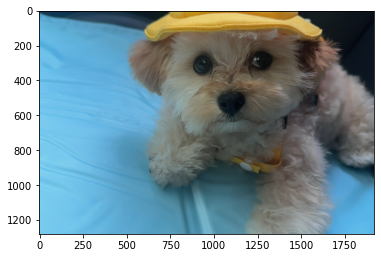

In [39]:
# 이미지 파일 경로 및 파일 가져오기
img_path, img_org = read_file(file_path='/aiffel/human_segmentation/images/dog.png')
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
show_img(change_color_channel(img_org))

#### (사진4) 강아지 사진 셸로우 포커스

0 background
12 dog


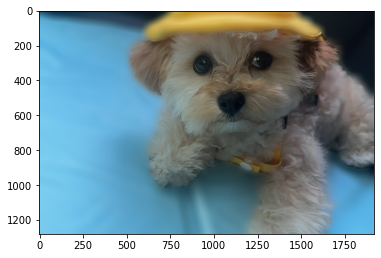

In [42]:
# 셸로우포커스 적용 후
img_res = seg_img(img_path, img_org, 'dog')
show_img(change_color_channel(img_res))

### (사진5) 얼굴 없는 강아지 사진

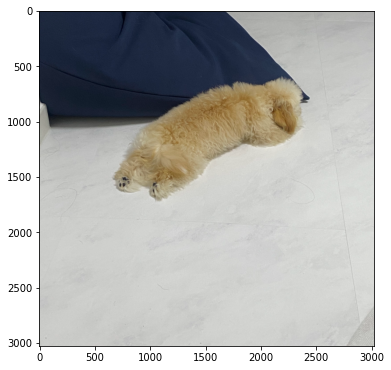

In [43]:
# 이미지 파일 경로 및 파일 가져오기
img_path, img_org = read_file(file_path='/aiffel/human_segmentation/images/dog_on_floor.png')
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
show_img(change_color_channel(img_org))

#### (사진5) 강아지 사진 셸로우 포커스

0 background
12 dog


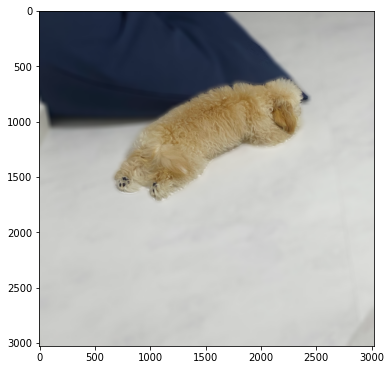

In [44]:
# 셸로우포커스 적용 후
img_res = seg_img(img_path, img_org, 'dog')
show_img(change_color_channel(img_res))

- 강아지의 경우 얼굴이 없어도 배경과 분리를 잘함

## 회고

(이슈1) 깔끔한 경계선 처리 불가
- 누끼따는 작업처럼 사람 누끼를 따는데 가장자리가 지저분하다고 느껴짐(사진3)
- 배경과 사람을 분리해서 다시 합성하는 과정을 거치다보니 경계선 부분이 블러처리된 듯한 느낌
- 이유가 뭘까? 픽셀 단위로 구분된 이미지에 라벨을 붙여서 1,0값을 주고 그걸 합치다보니 생기는 문제..? 
    - 픽셀을 엄청 작게하면 그만큼 세세하게 분리되겠지만 그러면 또 연산량이 너무 커질 거 같음
    - 다른 해결 방법을 생각해보면 좋을 듯
    
(이슈2) 머리카락이나 얇은 물체의 경우 그냥 배경으로 처리함


(이슈3) 강아지가 쓰고 있는 모자도 배경 처리함 - 사진4

(이슈4) 사람 얼굴이 없을 경우 인식이 안되는 듯함(사진3)
- 강아지(사진5)의 경우 얼굴 없이도 인식이 됐는데 
- 아마 라벨 출력한 부분을 봤을 때 사진3 관련 라벨에서 'person'이 없는 걸로 보아 사람 자체로 인식을 못한듯
    - 강아지나 말 같은 걸로 다시 돌려보면 구분이 될까? 
    - 말과 강아지로 다시 해봐도 여전히 인식은 안됨